In [2130]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from scipy.stats import norm
from scipy.spatial import cKDTree
from scipy.linalg import cho_solve
import time

if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')

whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]


def zbl(rij, Zi, Zj):
    
    e0 = 55.26349406e-4

    const = 1/(4*np.pi*e0)

    a = 0.46850/(Zi**0.23 + Zj**0.23)	

    x = rij/a

    x = x[:, np.newaxis]

    amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
    exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

    phi = np.sum(amplitude * np.exp(-exponent * x), axis=1)
        
    return const*phi*(Zi*Zj/rij)

In [2131]:
class GP_BayesOpt():

    def __init__(self, x_test, y_test, n_knots = 4, basis_type = 'log_normal', reg = 1e-3, beta = 1):

        self.n_knots = n_knots
        self.x_test = x_test
        self.y_test = y_test

        self.basis_type = basis_type

        self.x_knot = np.linspace(1, 3, n_knots)

        self.reg = reg

        self.beta = beta

    def rand_sample_points(self):

        y_knot = np.random.uniform(low = -1, high = 1, size = (self.n_knots,1))

        return y_knot

    def fit_weights(self,x = None, y = None):

        if y is None:
            
            y = self.rand_sample_points()
        
        if x is None:

            x = self.x_knot
        
        phi = self.basis_functions(x)

        self.weights = np.linalg.solve(phi.T@phi + self.reg*np.eye(phi.shape[1]), phi.T@y)

    def basis_functions(self, x):

        if self.basis_type == 'log_normal':

            sigma = 0.4

            offset = np.exp(-sigma**2)
            
            x_offset = np.clip(x[:,np.newaxis] - self.x_knot + offset, a_min=1e-2, a_max=None)
        
            phi = (1/ (x_offset*np.sqrt(2*np.pi)*sigma))*np.exp(-0.5*(np.log(x_offset)/sigma)**2)
        
        elif self.basis_type == 'normal':

            sigma = 0.25

            x_offset = x[:,np.newaxis] - self.x_knot

            phi = np.exp(-0.5*(x_offset/sigma)**2)

        elif self.basis_type == 'poly':
            
            x = x.flatten()
            phi = np.array([x**i for i in range(self.n_knots)], dtype=float).T
        return phi
    
    def predict(self, x = None):

        if x is None:
            return self.basis_functions(self.x_test)@self.weights
        else:
            return self.basis_functions(x)@self.weights

    def loss(self):

        y_predict = self.predict()

        return np.linalg.norm(y_predict-self.y_test)/len(self.y_test)
    
    def acquisition(self, x):
        
        if x.ndim == 1:
            x = x.reshape(1,-1)
        elif x.shape[0] > x.shape[1]:
            x = x.T

        f = self.gpr_bayes.kernel_(x, self.gpr_bayes.X_train_).T
        
        z = cho_solve((self.gpr_bayes.L_,True), f)

        mu  = np.dot(f.T, self.gpr_bayes.alpha_.reshape(-1,1)) 
        
        var = self.kernel_amplitude - np.dot(f.T, z)

        std = np.sqrt(var)

        alpha = mu - self.beta * std

        d_std = (1/(2*self.kernel_sigma**2*std)) *  ( ((x - self.gpr_bayes.X_train_).T*z.T) @ f   + ((x - self.gpr_bayes.X_train_).T*f.T) @ z)

        d_mu  = -(1/self.kernel_sigma**2) *  ( (x - self.gpr_bayes.X_train_)*f ).T @ self.gpr_bayes.alpha_.reshape(-1,1) 

        d_alpha = d_mu - self.beta*d_std

        return alpha.item(), d_alpha

    def Adam_opt_acquisition(self, x_init, n_iterations = 1000, lr = 1e-3, beta = [0.9,0.999], eps = 1e-8, convergence_criterion = 1e-5):
        
        m = 0
        v = 0
        t = 0
        converged = False

        theta = x_init

        if theta.ndim == 1:
            theta = theta.reshape(-1,1)

        while not converged or t < n_iterations:

            _, grad = self.acquisition(theta)

            m = beta[0]*m + (1 - beta[0])*grad
            v = beta[1]*v + (1 - beta[1])*grad**2

            m_reg = m/(1 - beta[0])
            v_reg = v/(1 - beta[1])

            delta = lr*m_reg/(np.sqrt(v_reg) + eps)

            if np.linalg.norm(delta) < convergence_criterion:
                converged = True 
            
            theta = theta - delta

            t += 1
        
        return theta, grad
    
    def GD_opt_acquisition(self, x_init, n_iterations = 1000, lr = 1e-2, convergence_criterion = 1e-5):

        converged = False

        theta = x_init

        if theta.ndim == 1:
            theta = theta.reshape(-1,1)
        
        t = 0

        while not converged or t < n_iterations:

            _, grad = self.acquisition(theta)

            delta = lr * grad

            if np.linalg.norm(delta) < convergence_criterion:
                converged = True 
            
            theta = theta - delta

            t += 1

        return theta, grad

    
    def bayes_opt(self, n_samples):
        
        n_bayes_samples  = n_samples//10

        n_rand_samples = n_samples - n_bayes_samples

        x_samples = np.zeros((n_samples, self.n_knots))

        y_samples = np.zeros((n_samples,))

        for i in range(n_rand_samples):
            
            self.fit_weights()

            x_samples[i] = self.weights.flatten()

            # new_x_sample = self.rand_sample_points()

            # x_samples[i] = new_x_sample.flatten()

            # self.fit_weights(self.x_knot, new_x_sample)

            y_samples[i] = self.loss()

        kdtree = cKDTree(x_samples)

        closest_distances, _ = kdtree.query(x_samples, k=2)

        self.kernel_sigma = np.clip(closest_distances.max(),a_min=1, a_max = None)

        self.kernel_amplitude = y_samples.mean()

        kernel = kernels.ConstantKernel(self.kernel_amplitude, constant_value_bounds='fixed') * kernels.RBF(self.kernel_sigma,length_scale_bounds='fixed')

        tic = time.perf_counter()
        self.gpr_bayes = GaussianProcessRegressor(kernel, alpha= 1e-3).fit(x_samples[:n_rand_samples], y_samples[:n_rand_samples])
        toc = time.perf_counter()

        print('GPR fitting time: %f' % (toc - tic))

        for i in range(n_bayes_samples):

            idx = i + n_rand_samples

            tic = time.perf_counter()

            rand_int = np.random.randint(low = 0, high = idx)
            new_x_sample, _  = self.Adam_opt_acquisition(x_samples[rand_int])

            toc = time.perf_counter()

            if i == 0:
                print('Acquisition Optimization Time: %f' % (toc - tic))
                
            x_samples[idx] = new_x_sample.flatten()

            self.weights = new_x_sample
            
            y_samples[idx] = self.loss()

            self.gpr_bayes = GaussianProcessRegressor(kernel, alpha= 1e-3).fit(x_samples[:idx + 1], y_samples[:idx + 1])

        return x_samples,y_samples
        

In [2132]:
x_test = whe[100:,0]
y_test = whe[100:,1] - zbl(whe[100:,0], 74, 2)

inst = GP_BayesOpt(x_test, y_test, n_knots=5, basis_type='log_normal', reg = 1e-3)
inst.fit_weights(x_test, y_test)

inst.loss()

0.0022348210415035373

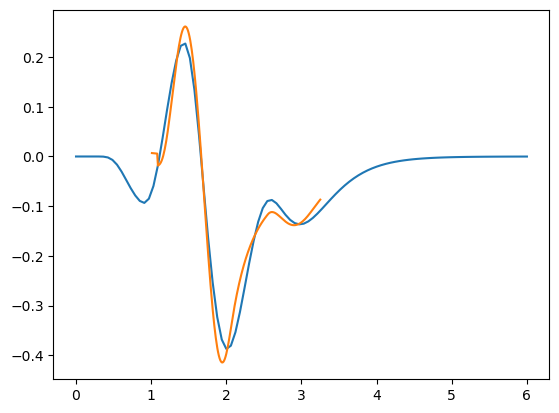

In [2133]:

x_predict = np.linspace(0,6,100)
y_predict = inst.predict(x_predict)

plt.plot(x_predict,y_predict)

plt.plot(x_test, y_test)

In [2134]:
w, f = inst.bayes_opt(1000)
print(inst.gpr_bayes.log_marginal_likelihood())

print(inst.gpr_bayes.kernel_)

GPR fitting time: 0.024940
Acquisition Optimization Time: 3.191600
1696.9643329241203
0.708**2 * RBF(length_scale=1)


0.17610728021462307 [-0.05505506 -0.05505506 -0.05505506 -0.05505506 -0.05505506]


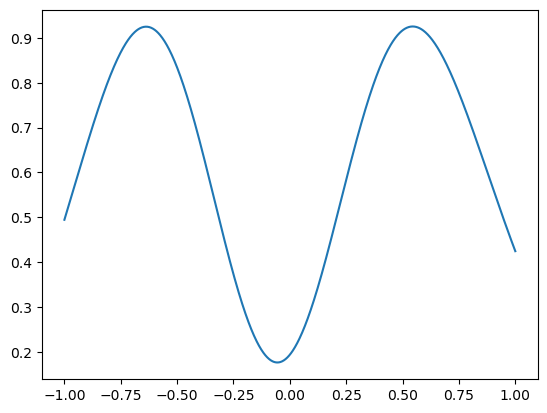

In [2135]:
x = np.linspace(-1,1,1000).reshape(-1,1)

x = np.hstack([x for i in range(len(inst.weights))])
y, std = inst.gpr_bayes.predict(x, return_std=True)

plt.plot(x[:,0],y)

# plt.scatter(w[:,0],f)

print(y.min(), x[y.argmin()])

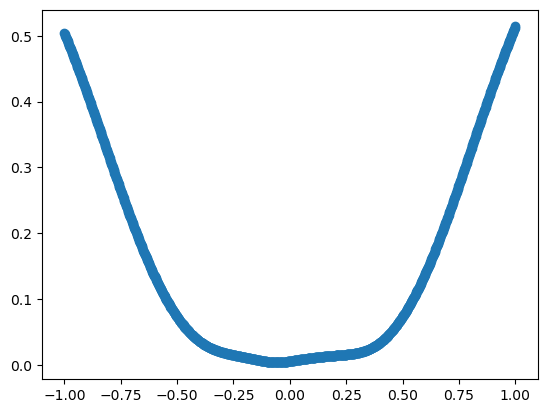

In [2136]:
plt.scatter(x[:,0],std)

In [2137]:
# x = x[y.argmin()]*np.ones((1,1))

# mu_gpr, std_gpr = inst.gpr_bayes.predict(x, return_std=True)

# mu_gpr1, std_gpr1 = inst.gpr_bayes.predict(x + 1e-4, return_std=True)

# d_mu = (mu_gpr1 - mu_gpr)/1e-4
# d_std = (std_gpr1 - std_gpr)/1e-4

# mu, std, alpha, d_alpha = inst.acquisition(x)

# print(mu, mu_gpr, std, std_gpr)

# print(d_mu, alpha, d_std, d_alpha)

In [2138]:
a = w[f.argmin()]

tic = time.perf_counter()
alpha, d_alpha = inst.acquisition(a)
toc = time.perf_counter()

print(toc - tic)

tic = time.perf_counter()
theta, grad = inst.GD_opt_acquisition(a, n_iterations=1000, lr = 1e-2)
toc = time.perf_counter()

print(toc - tic)

tic = time.perf_counter()
theta, grad = inst.Adam_opt_acquisition(a, n_iterations=1000, lr = 1e-2)
toc = time.perf_counter()

print(toc - tic)

print(theta, grad)

0.003643958014436066
1.277779083000496
1.2562877910095267
[[-0.08567037]
 [-0.03915376]
 [-0.05023567]
 [-0.0698826 ]
 [-0.03901095]] [[-4.76675990e-14]
 [ 9.50585097e-14]
 [-3.32929214e-14]
 [-1.03757714e-13]
 [-9.05931146e-14]]


In [2139]:
inst.weights = theta
new_loss = inst.loss()
new_alpha, _ = inst.acquisition(theta)
print(alpha, new_alpha, new_loss, inst.gpr_bayes.y_train_.min())

print(np.linalg.norm(w[f.argmin()].flatten() - theta.flatten()))

0.17268464151771218 0.1725618302991863 0.17333976897657902 0.17307527223101354
0.04076474576410084


[[-0.08567037]
 [-0.03915376]
 [-0.05023567]
 [-0.0698826 ]
 [-0.03901095]] [-0.09374359  0.28522167 -0.50275484  0.13828083 -0.1311466 ]


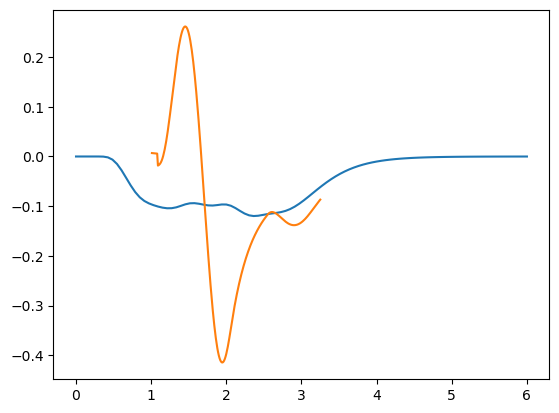

In [2140]:
x = np.linspace(0,6,100)

y = inst.predict(x)
inst.fit_weights(x_test, y_test)
theta_prime = inst.weights

print(theta, theta_prime)
plt.plot(x, y)
plt.plot(x_test, y_test)

In [2141]:
print(inst.acquisition(theta_prime))

mu, std = inst.gpr_bayes.predict(theta_prime.reshape(1,-1), return_std=True)

print(mu, std)

inst.weights = theta_prime

loss = inst.loss()
print(loss)

(0.23052195926003435, array([[ 0.1101817 ],
       [ 0.11024626],
       [-0.18620458],
       [-0.04315446],
       [-0.02880641]]))
[0.24326871] [0.01274675]
0.0022348210415035373
